In [ ]:
#https://www.youtube.com/watch?v=7kLi8u2dJz0

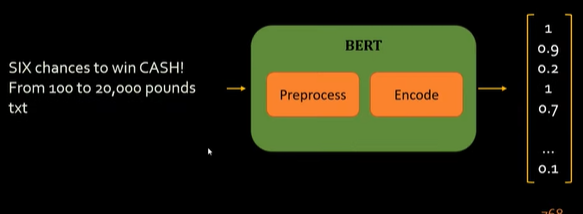

In [ ]:
pip install tensorflow-text

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
import pandas as pd

# Specify the encoding when reading the CSV file
df = pd.read_csv("spam.csv", encoding='latin1')  # Use 'latin1' encoding in this example, but you may need to adjust it.

# Now you can work with the DataFrame
df.head(5)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.drop(columns =['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [ ]:
# Create a dictionary for renaming the columns
new_column_names = {'v1': 'Category', 'v2': 'Message'}

# Use the rename method to apply the renaming
df.rename(columns=new_column_names, inplace=True)

In [ ]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [ ]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [ ]:
747/4825

0.15481865284974095

In [ ]:
#15% spam emails, 85% ham emails: This indicates class imbalance.

In [ ]:
#perform downsampling


In [ ]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [ ]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [ ]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [ ]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [ ]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [ ]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
2939,spam,You have 1 new message. Please call 08712400200.,1
2573,spam,Congrats 2 mobile 3G Videophones R yours. call...,1
2449,ham,Then she dun believe wat?,0
3139,spam,sexy sexy cum and text me im wet and warm and ...,1
1542,ham,Now press conference da:),0


In [ ]:
#Split it into training and test data set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [ ]:
#import BERT model and get embeding vectors for few sample statements

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351724, -0.5132727 , -0.88845736, ..., -0.7474883 ,
        -0.75314754,  0.91964495],
       [-0.87208354, -0.50543964, -0.94446665, ..., -0.85847497,
        -0.71745336,  0.88082975]], dtype=float32)>

In [ ]:
#Get embeding vectors for few sample words
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [ ]:
#Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits.

In [ ]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703803]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes.

In [ ]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872034]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above.

In [ ]:
#Build Model
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 22s 316ms/step - loss: 0.6691 - accuracy: 0.6009 - precision: 0.6004 - recall: 0.6036
Epoch 2/10
35/35 [==============================] - 11s 316ms/step - loss: 0.5356 - accuracy: 0.7812 - precision: 0.7586 - recall: 0.8250
Epoch 3/10
35/35 [==============================] - 11s 310ms/step - loss: 0.4563 - accuracy: 0.8384 - precision: 0.8452 - recall: 0.8286
Epoch 4/10
35/35 [==============================] - 11s 312ms/step - loss: 0.4039 - accuracy: 0.8670 - precision: 0.8489 - recall: 0.8929
Epoch 5/10
35/35 [==============================] - 11s 316ms/step - loss: 0.3707 - accuracy: 0.8804 - precision: 0.8586 - recall: 0.9107
Epoch 6/10
35/35 [==============================] - 11s 317ms/step - loss: 0.3431 - accuracy: 0.8893 - precision: 0.8707 - recall: 0.9143
Epoch 7/10
35/35 [==============================] - 11s 324ms/step - loss: 0.3144 - accuracy: 0.9036 - precision: 0.8831 - recall: 0.9304
Epoch 8/10
35/35 [================

In [ ]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 5s 332ms/step - loss: 0.2773 - accuracy: 0.9118 - precision: 0.8969 - recall: 0.9305


[0.2773352563381195,
 0.9117646813392639,
 0.8969072103500366,
 0.9304812550544739]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 4s 297ms/step


In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[167,  20],
       [ 13, 174]])

Text(50.722222222222214, 0.5, 'Truth')

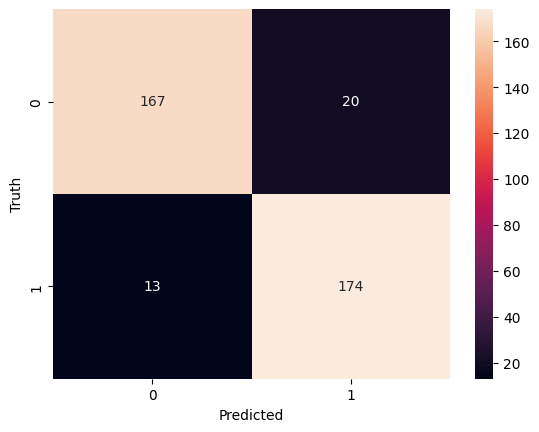

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       187
           1       0.90      0.93      0.91       187

    accuracy                           0.91       374
   macro avg       0.91      0.91      0.91       374
weighted avg       0.91      0.91      0.91       374



In [ ]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 791ms/step


array([[0.77419466],
       [0.82371294],
       [0.7874452 ],
       [0.22640261],
       [0.1327868 ]], dtype=float32)